In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
# 기본 경로
image_path = '/content/gdrive/MyDrive/pytest_img/'
# 기본 저장 경로
save_path = '/content/gdrive/MyDrive/pytest_img/_generated_images/'

In [3]:
if not os.path.exists(os.path.join(save_path, "pix2pix/")):
  os.makedirs(os.path.join(os.path.join(save_path, "pix2pix/")))

In [4]:
# tf.io.read_file()은 이미지 파일을 읽어 바이트 타입의 텐서플로 텐서를 반환한다
# tf.io.decode_jpeg()은 바이트 데이터를 입력으로 받아 (높이, 너비, 채널)의 3차원 이미지 텐서로 변환한다
sample_image = tf.io.read_file(image_path+'facades/train/1.jpg')
sample_image = tf.io.decode_jpeg(sample_image) # RGB 변환
print(sample_image.shape)

(256, 512, 3)


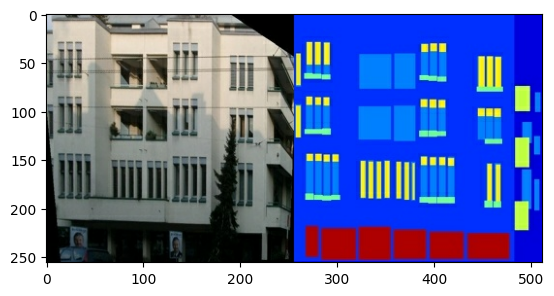

In [5]:
from matplotlib import pyplot as plt
from IPython import display
plt.figure()
plt.imshow(sample_image)

In [6]:
def load(image_file):
  image = tf.io.read_file(image_file) # 이미지를 바이트 타입으로 읽는다
  image = tf.io.decode_jpeg(image) # 바이트 타입의 이미지를 JPEG 형식으로 디코딩. 각 픽셀은 0~255의 값
  # 이미지가 가로 방향의 두 부분으로 나뉘어 있다고 가정하고, 중간 지점에서 분할한다
  w = tf.shape(image)[1] # (256, 512, 3)의 width에 해당하는 512.
  w = w // 2 # 절반값 구함 (256)
  input_image = image[:, w:, :] # 입력 이미지. 오른쪽 절반 추출 (건물 아키텍처 레이블 이미지)
  real_image = image[:, :w, :] # 정답 이미지. 왼쪽 절반 추출 (실제 건물 파사드 이미지)
  # 두 이미지를 float32 타입으로 변환
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  return input_image, real_image

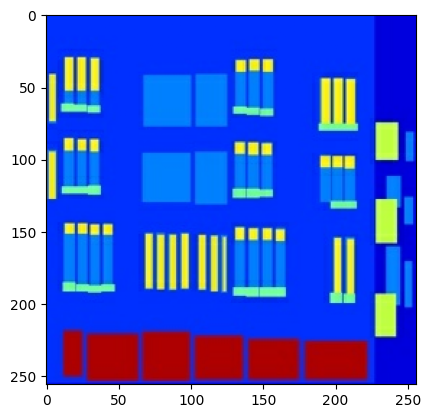

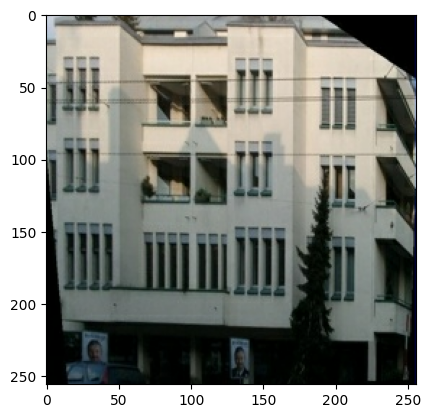

In [7]:
inp, re = load(image_path+"facades/train/1.jpg")

# 255로 나누어 정규화한 뒤 시각화 (0 ~ 1 사이의 값)
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [8]:
BUFFER_SIZE = 400 # train 데이터로 사용되는 이미지의 개수
BATCH_SIZE = 1 # 한 번에 처리되는 이미지의 수. 일반적으로 1을 사용
IMG_HEIGHT = 256 # 변경되는 이미지의 높이
IMG_WIDTH = 256 # 변경되는 이미지의 너비

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image, real_image

In [9]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0) # 두 이미지를 배치 차원을 추가해 결합 (2, 높이, 너비, 채널)
  cropped_image = tf.image.random_crop( # 랜덤 위치에서 이미지를 자르는 함수
  stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3]) # 2개로, 설정된 높이, 설정된 너비, 3 채널로 자름
  return cropped_image[0], cropped_image[1] # 잘린 두 개의 이미지를 return

In [10]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  return input_image, real_image

In [11]:
def random_jitter(input_image, real_image):
  # 이미지를 자르기 전에 286x286으로 약간 키워 자르기 과정에서 다양한 부분을 포함할 수 있게 한다
  input_image, real_image = resize(input_image, real_image, 286, 286)
  # 랜덤 crop을 수행한다. 이미지는 다시 256x256이 된다
  input_image, real_image = random_crop(input_image, real_image)
  if tf.random.uniform(()) > 0.5: # 50%의 확률로 입력 이미지와 정답 이미지를 좌우 반전한다 (데이터 증강)
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
  return input_image, real_image # 입력 이미지와 정답 이미지 return

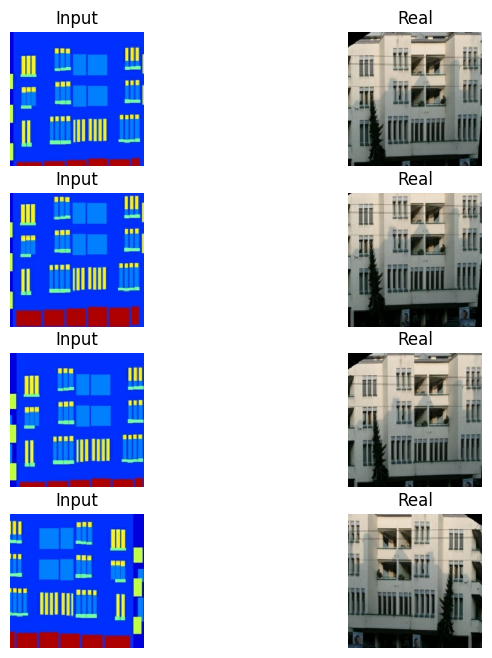

In [16]:
plt.figure(figsize=(8, 8)) # 이미지의 전체 사이즈 설정
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re) # 데이터 증강
  plt.subplot(4, 2, 2*i + 1) # 4x2 서브플롯의 각 행 첫 번째 열에 배치 (홀수)
  plt.imshow(rj_inp / 255.0)
  plt.title("Input")
  plt.axis("off")
  plt.subplot(4, 2, 2*i + 2) # 4x2 서브플롯의 각 행 두 번째 열에 배치 (짝수)
  plt.imshow(rj_re / 255.0)
  plt.title("Real")
  plt.axis("off")
plt.show()

In [17]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

In [18]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

In [19]:
train_dataset = tf.data.Dataset.list_files(image_path + "facades/train/*.jpg")
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE) # 데이터셋을 BUFFER_SIZE 만큼씩 무작위로 섞는다
train_dataset = train_dataset.batch(BATCH_SIZE) # 데이터셋을 BATCH_SIZE 만큼씩 배치로 분할한다

In [23]:
test_dataset = tf.data.Dataset.list_files(image_path + "facades/test/*.jpg")
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [24]:
def downsample(filters, size, apply_batchnorm=True): # 사용할 필터의 수, 필터의 크기, 배치정규화 여부
  initializer = tf.random_normal_initializer(0., 0.02) # 가중치 초기화. 평균 0, 표준편차 0.02
  result = tf.keras.Sequential() # 모델 생성
  """
  모델에 합성곱 층 추가. 입력 데이터에 strides=2와 padding=‘same’의 2D 합성곱 수행으로 입력 이미지가 절반 크기로 감소됨
  배치정규화로 편향 계산은 무효화되므로
  계산의 단순함을 위해 편향은 사용하지 않음
  """
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization()) # 배치정규화 층 추가
  """
  음수에서도 작은 기울기를 허용하는 LeakyReLU 활성화 함수 사용(기본값 0.3)
  특징을 추출하는 과정에서는 양수뿐 아니라, 음수도 받아들여
  다양한 정보를 학습할 수 있게 한다
  """
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [25]:
# 모델을 수행해서 결과를 확인해본다
# 필터 수 3, 필터 크기 4x4로 합성곱 연산을 수행하는 다운샘플링 모델을 생성한다
down_model = downsample(3, 4)
# 먼저 이미지에 배치 차원을 추가한 후,
# 생성된 모델로 이미지에 다운샘플링을 적용한다
# (256, 256, 3) → (1, 128, 128, 3)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape) # (1, 128, 128, 3) 으로 사이즈가 줄어들었다

(1, 128, 128, 3)


In [26]:
def upsample(filters, size, apply_dropout=False): # 사용할 필터의 수, 필터의 크기, 드롭아웃 적용 여부
  initializer = tf.random_normal_initializer(0., 0.02) # 가중치 초기화. 평균 0, 표준편차 0.02
  result = tf.keras.Sequential() # 모델 생성
  # 모델에 전치 컨볼루션(역합성곱) 층 추가. 입력 데이터에 0을 넣어 데이터를 키운 뒤 합성곱 연산하는 역합성곱을 통해 이미지의 사이즈를 키운다
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization()) # 배치정규화 층 추가

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5)) # 드롭아웃 층 층가
  result.add(tf.keras.layers.ReLU()) # 음수 입력에 0을 출력하는 ReLU 활성화 함수 사용 양수 범위의 픽셀을 강조해야 자연스러운 이미지가 재구성된다
  return result


In [27]:
# 모델을 수행해서 결과를 확인해본다
# 필터 수 3, 필터 크기 4x4으로 합성곱 연산을 수행하는 업샘플링 모델을 생성한다
up_model = upsample(3, 4)
# 앞에서 줄어든 이미지(1, 128, 128, 3)에 업샘플링을 적용한다
up_result = up_model(down_result)
print (up_result.shape) # (1, 256, 256, 3). 사이즈가 2배가 되어 본래 크기가 되었다

(1, 256, 256, 3)


In [29]:
up_model

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [ # 다운샘플링 스택. 이미지의 차원이 줄어든다
    downsample(64, 4, apply_batchnorm=False), # (batch_size, 128, 128, 64)
    downsample(128, 4), # (batch_size, 64, 64, 128)
    downsample(256, 4), # (batch_size, 32, 32, 256)
    downsample(512, 4), # (batch_size, 16, 16, 512)
    downsample(512, 4), # (batch_size, 8, 8, 512)
    downsample(512, 4), # (batch_size, 4, 4, 512)
    downsample(512, 4), # (batch_size, 2, 2, 512)
    downsample(512, 4), # (batch_size, 1, 1, 512)
  ]
  up_stack = [ # 업샘플링 스택. 이미지의 차원이 커진다
    upsample(512, 4, apply_dropout=True), # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (batch_size, 8, 8, 1024)
    upsample(512, 4), # (batch_size, 16, 16, 1024)
    upsample(256, 4), # (batch_size, 32, 32, 512)
    upsample(128, 4), # (batch_size, 64, 64, 256)
    upsample(64, 4), # (batch_size, 128, 128, 128)
  ]
  initializer = tf.random_normal_initializer(0., 0.02) # 평균 0, 표준편차 0.02
  last = tf.keras.layers.Conv2DTranspose(
      3, 4, # 채널 수가 3이 나오도록 filters의 수를 조정
      strides=2,
      padding='same',
      kernel_initializer=initializer,
      activation='tanh'
  ) # (batch_size, 256, 256, 3)
  x = inputs # 모델의 입력을 x에 할당

  skips = []
  for down in down_stack: # 다운샘플링 스택을 하나씩 실행
    x = down(x) # 각 다운샘플링 레이어에 입력 x를 전달하여 받음
    skips.append(x) # 각 다운샘플링 레이어를 통과한 x를 리스트에 추가

  skips = reversed(skips[:-1]) # 스킵 리스트의 마지막 직전까지만 슬라이싱한 뒤, 모든 요소를 역순으로 정렬

  # 각각의 업샘플링 레이어와 스킵 리스트를 하나씩 순회
  for up, skip in zip(up_stack, skips):
    x = up(x) # 각 업샘플링 레이어에 x를 전달하여 받음
    # 업샘플링된 이미지 x와 현재 스킵 리스트 요소를 합침
    # 고해상도 정보와 저해상도 정보를 결합하는 것
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x) # last 레이어를 통과하여 최종 출력을 얻음
  # 입력과 출력을 지정하여 케라스 모델을 생성하고, return
  return tf.keras.Model(inputs=inputs, outputs=x)